On charge les librairies dont on aura besoin

In [20]:
#On importe les modules nécessaires au traitement de la base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

On charge la base de donnée open food fact directement depuis internet 

In [4]:
# Charger le fichier CSV
url_path = 'https://www.data.gouv.fr/fr/datasets/r/164c9e57-32a7-4f5b-8891-26af10f91072'
# Charger le fichier CSV dans un DataFrame pandas
df = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


C:\Users\luneb\AppData\Local\Temp\ipykernel_22012\3597449632.py:4: DtypeWarning: Columns (0,9,10,12,13,14,15,21,22,23,24,25,29,30,31,32,33,34,35,42,44,45,46,49,50,51,54,65,70,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


On regarde si elle a bien été importée en regardant les premières lignes et des lignes prises au hasard dans la base 

In [5]:
# Afficher les premières lignes du DataFrame pour voir les données
print(df.head())
#On vérifie que la base est bien chargée
#on affiche 5 lignes aléatoires 
print(df.sample(5))

#on veut connaître le format de la base 
print ("Le dataset compte {} lignes et {} variables".format(df.shape[0], df.shape[1]))

                     code                                                url  \
0       00000000000000225  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000000000207025004  http://world-fr.openfoodfacts.org/produit/0000...   
2    00000000000003429145  http://world-fr.openfoodfacts.org/produit/0000...   
3    00000000000026772226  http://world-fr.openfoodfacts.org/produit/0000...   
4           0000000000017  http://world-fr.openfoodfacts.org/produit/0000...   

          creator   created_t      created_datetime  last_modified_t  \
0  nutrinet-sante  1623855208  2021-06-16T14:53:28Z       1692101569   
1         kiliweb  1656948610  2022-07-04T15:30:10Z       1656948613   
2         kiliweb  1630483911  2021-09-01T08:11:51Z       1682646029   
3         kiliweb  1654250311  2022-06-03T09:58:31Z       1654270474   
4         kiliweb  1529059080  2018-06-15T10:38:00Z       1561463718   

  last_modified_datetime last_modified_by      product_name  \
0   2023-08-15T12:12:49

On cherche à connaître le nom des variables pour savoir les traitements que nous pourrions faire sur la base 

In [6]:
for column_name in df.columns:
    print(column_name)


code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
last_modified_by
product_name
abbreviated_product_name
generic_name
quantity
packaging
packaging_tags
packaging_fr
packaging_text
brands
brands_tags
categories
categories_tags
categories_fr
origins
origins_tags
origins_fr
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_fr
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_fr
ingredients_text
ingredients_tags
ingredients_analysis_tags
allergens
allergens_fr
traces
traces_tags
traces_fr
serving_size
serving_quantity
no_nutrition_data
additives_n
additives
additives_tags
additives_fr
nutriscore_score
nutriscore_grade
nova_group
pnns_groups_1
pnns_groups_2
food_groups
food_groups_tags
food_groups_fr
states
states_tags
states_fr
brand_owner
ecoscore_score
ecoscore_grade
nutrient_levels_tags
product_quantity
owner
data_quality_errors_tags
unique_scans_n
popular

On s'intéresse à la variable pays qui indique les pays dans lesquels sont commercialisés les produits qui composent la base de donnée. On va utiliser cette variable pour faire un premier nettoyage de la base pour s'intéresser uniquement aux produits commercialisés en France 

In [7]:
name_values_first_100 = df['countries_tags'].iloc[:100]
print("Les 100 premières valeurs dans la colonne 'Name':")
print(name_values_first_100)


Les 100 premières valeurs dans la colonne 'Name':
0      en:france
1     en:germany
2       en:spain
3      en:france
4      en:france
         ...    
95     en:france
96     en:france
97     en:france
98     en:france
99     en:france
Name: countries_tags, Length: 100, dtype: object


In [8]:
# On conserve uniquement les produits vendus en France en excluant les valeurs nulles
df_france = df[df['countries_tags'].str.lower().str.contains('en:france') & df['countries_tags'].notna()]

#on regarde combien de lignes il reste dans la base
print ("Le dataset France compte {} lignes et {} variables".format(df_france.shape[0], df.shape[1]))



Le dataset France compte 1012081 lignes et 203 variables


On procède à un 2ème nettoyage de la base de donnée en enlevant les lignes qui possèdent trop de valeurs nulles 

In [9]:
#On calcule le taux de remplissage des variables
def null_factor(df):
  null_rate = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  return null_rate


C:\Users\luneb\AppData\Local\Temp\ipykernel_22012\115072967.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


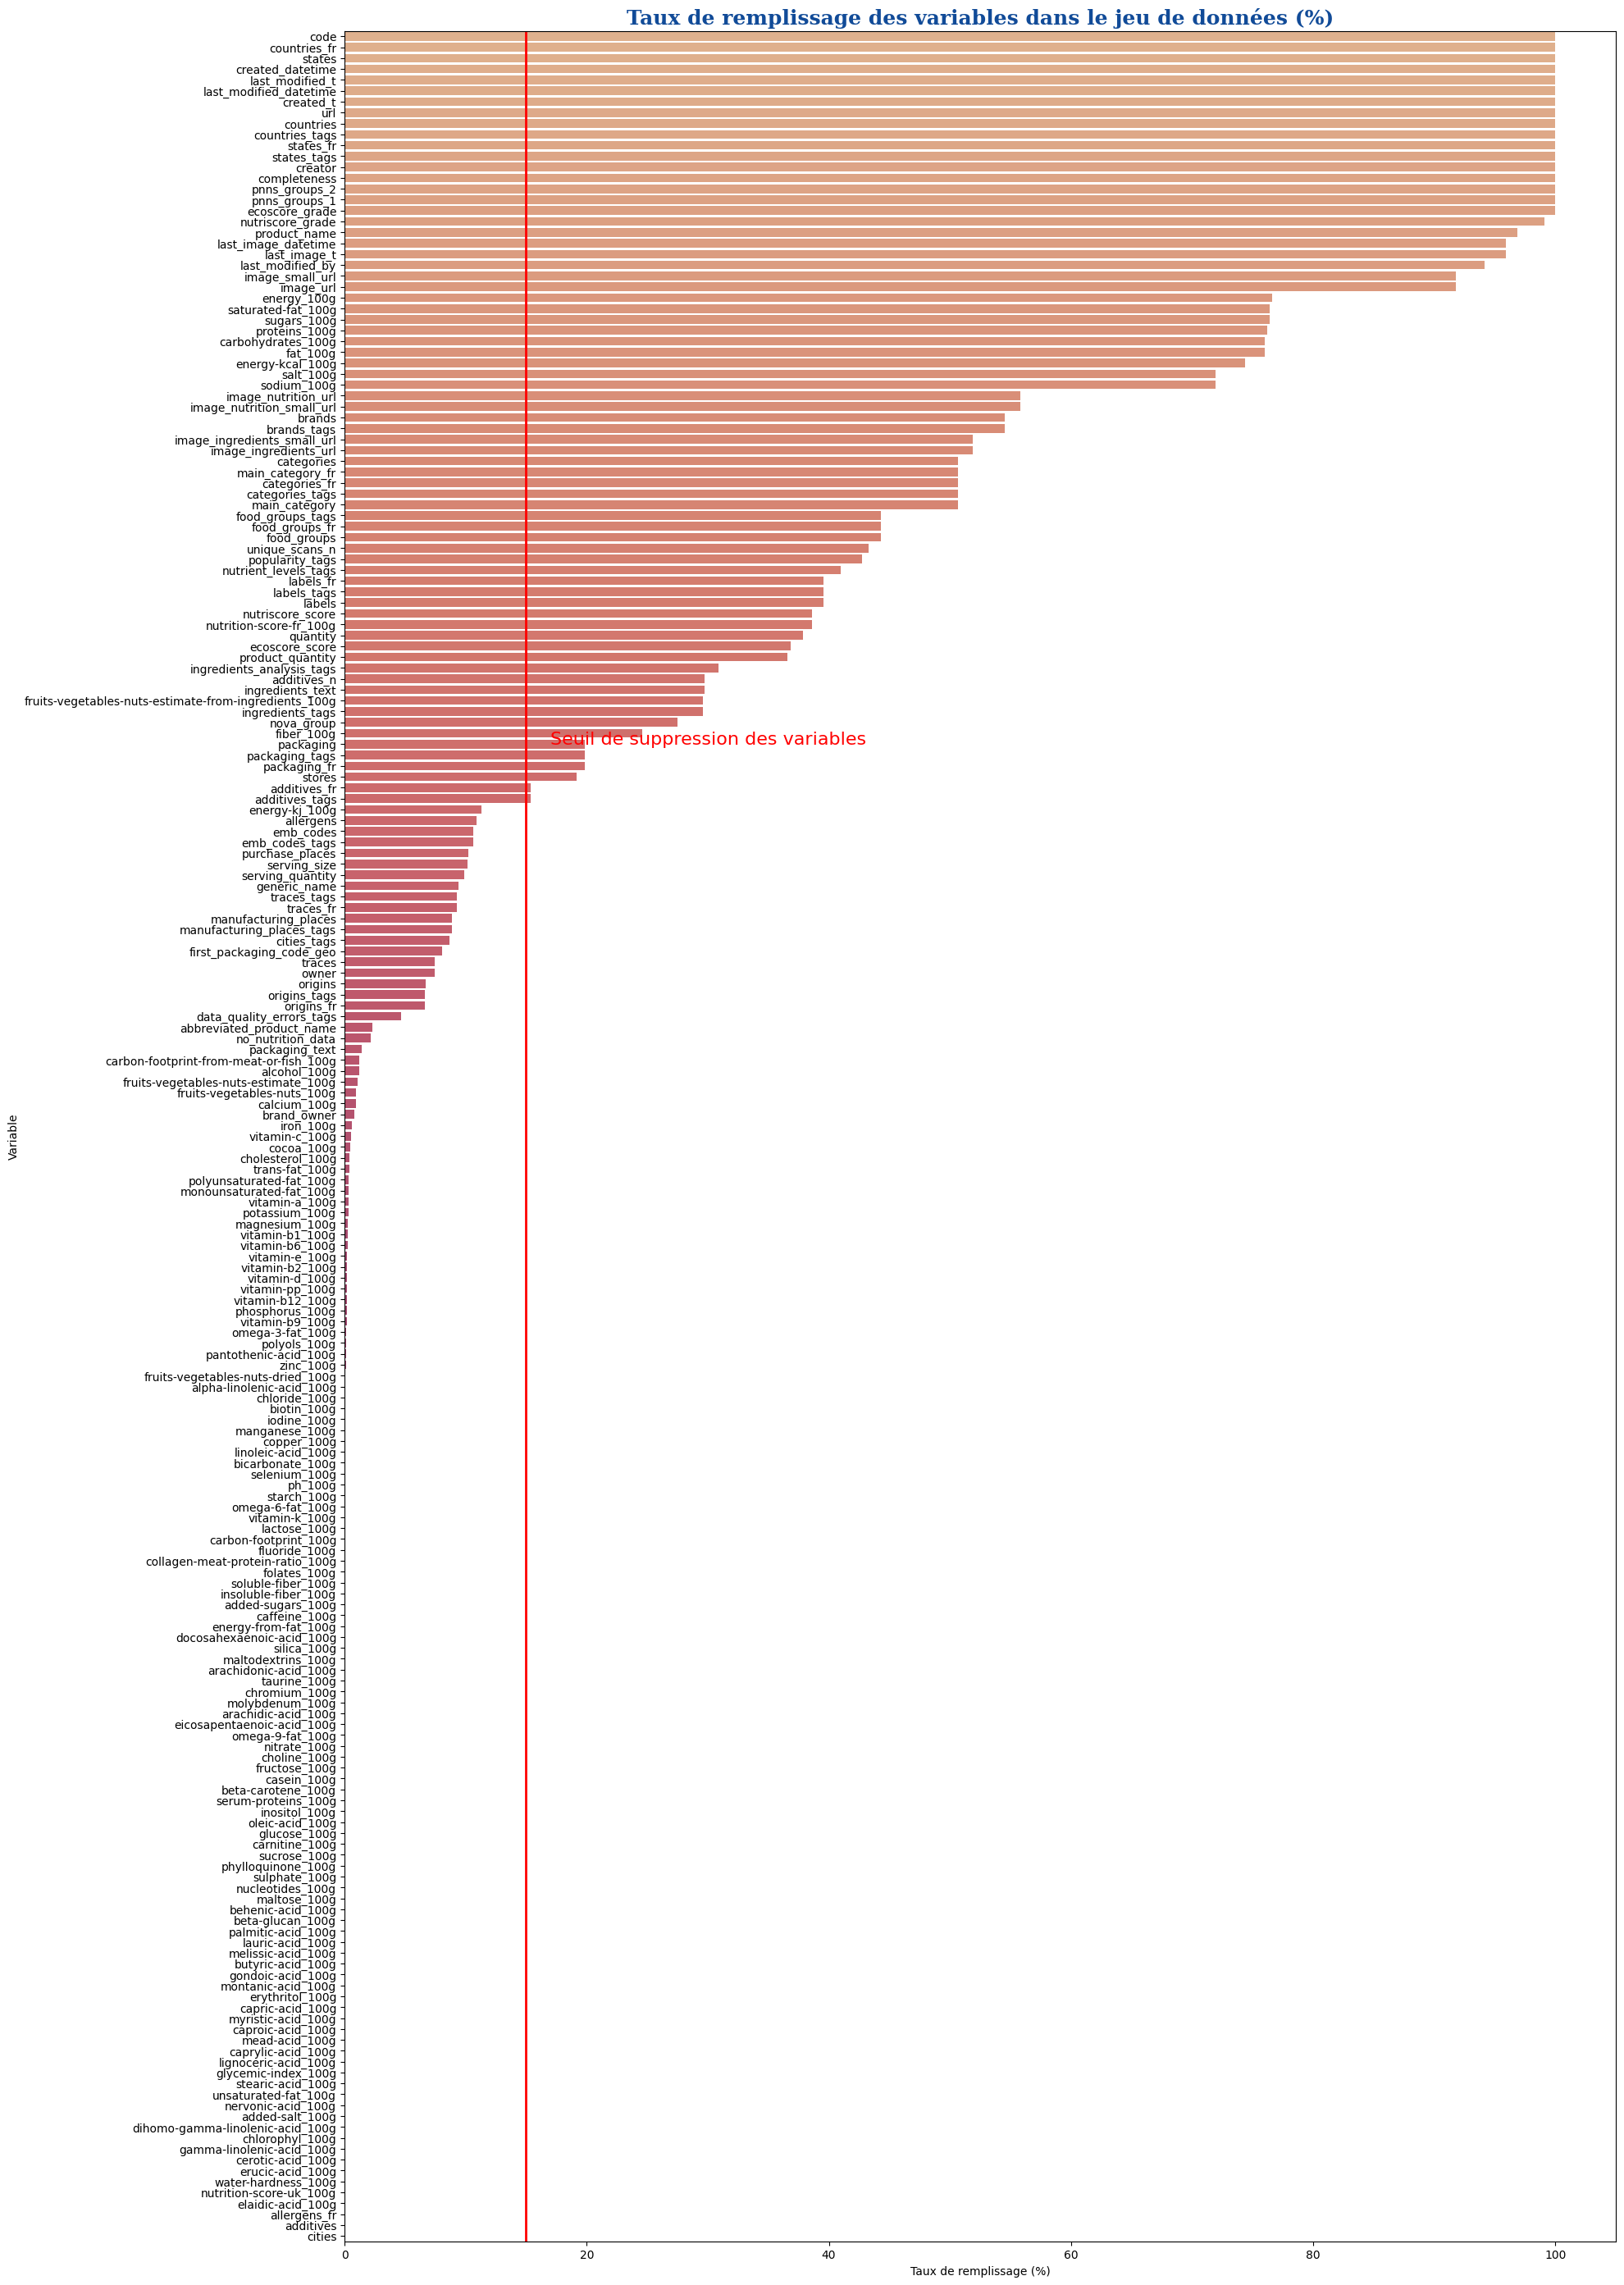

In [10]:
#Nous alllons désormais commencer à nettoyer la base de données en enlevant les colonnes peu remplis. 

filling_features = null_factor(df_france)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 15

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [11]:
seuil = 50
variable_conserve = list(filling_features.loc[filling_features['Taux_de_Null'] >= seuil, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
df_france_cleaned = df_france[variable_conserve]

# Affichage du résultat
print ("Le dataset France_cleaned compte {} lignes et {} variables".format(df_france_cleaned.shape[0], df_france_cleaned.shape[1]))

for column_name in df_france_cleaned.columns:
    print(column_name)


Le dataset France_cleaned compte 1012081 lignes et 44 variables
code
countries_fr
states
created_datetime
last_modified_t
last_modified_datetime
created_t
url
countries
countries_tags
states_fr
states_tags
creator
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
last_image_datetime
last_image_t
last_modified_by
image_small_url
image_url
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
carbohydrates_100g
fat_100g
energy-kcal_100g
salt_100g
sodium_100g
image_nutrition_url
image_nutrition_small_url
brands
brands_tags
image_ingredients_small_url
image_ingredients_url
categories
main_category_fr
categories_fr
categories_tags
main_category


In [12]:
name_values_first_100 = df['pnns_groups_2'].iloc[:1000]
print("Les 1000 premières valeurs dans la colonne 'Name':")
print(name_values_first_100)

Les 1000 premières valeurs dans la colonne 'Name':
0              Vegetables
1                 unknown
2                 unknown
3          Dairy desserts
4                 unknown
              ...        
995       Milk and yogurt
996    Biscuits and cakes
997                Sweets
998               unknown
999              Pastries
Name: pnns_groups_2, Length: 1000, dtype: object


On fait un 3ème nettoyage en enlevant les variables qui ne nous intéressent pas 

In [13]:
#On supprime les variables inutiles pour le reste du projet

colonne_supprimer = [col for col in df_france_cleaned.columns if 'url' in col or 'image' in col or "categories" in col or "last" in col or "states" in col]
df_france_cleaned = df_france_cleaned.drop(columns=colonne_supprimer)


print ("Le dataset France_cleaned compte {} lignes et {} variables".format(df_france_cleaned.shape[0], df_france_cleaned.shape[1]))

for column_name in df_france_cleaned.columns:
    print(column_name)




Le dataset France_cleaned compte 1012081 lignes et 26 variables
code
countries_fr
created_datetime
created_t
countries
countries_tags
creator
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
carbohydrates_100g
fat_100g
energy-kcal_100g
salt_100g
sodium_100g
brands
brands_tags
main_category_fr
main_category


On regarde la dimension de notre base nettoyée avant de commencer l'analyse 

In [14]:
#première analyse statistique
print(df_france_cleaned.describe())

df_france_cleaned = df_france_cleaned[(df_france_cleaned['nutriscore_grade'].isnull()==False)]
print ("Le dataset France compte {} lignes et {} variables".format(df_france_cleaned.shape[0], df_france_cleaned.shape[1]))





          created_t  completeness   energy_100g  saturated-fat_100g  \
count  1.012081e+06  1.012079e+06  7.756440e+05       773524.000000   
mean   1.565334e+09  4.793576e-01  7.671045e+10            5.411002   
std    6.696636e+07  2.380618e-01  6.755939e+13            7.974721   
min    1.328021e+09  5.000000e-02  0.000000e+00            0.000000   
25%    1.523222e+09  2.750000e-01  4.730000e+02            0.200000   
50%    1.554317e+09  3.875000e-01  1.096000e+03            2.000000   
75%    1.614502e+09  6.500000e-01  1.674000e+03            8.000000   
max    1.702278e+09  1.100000e+00  5.950000e+16          900.000000   

         sugars_100g  proteins_100g  carbohydrates_100g       fat_100g  \
count  773077.000000  771140.000000       769483.000000  769392.000000   
mean       13.631506       8.947336           27.044419      14.269024   
std        20.020207      10.080810           27.751246      17.682333   
min        -0.100000     -19.000000            0.000000      -2.

On s'intéresse au Nutriscore: la première partie de notre travail va consister à compléter les valeurs manquantes de Nutri-score en faisant un algo d'apprentissage. 

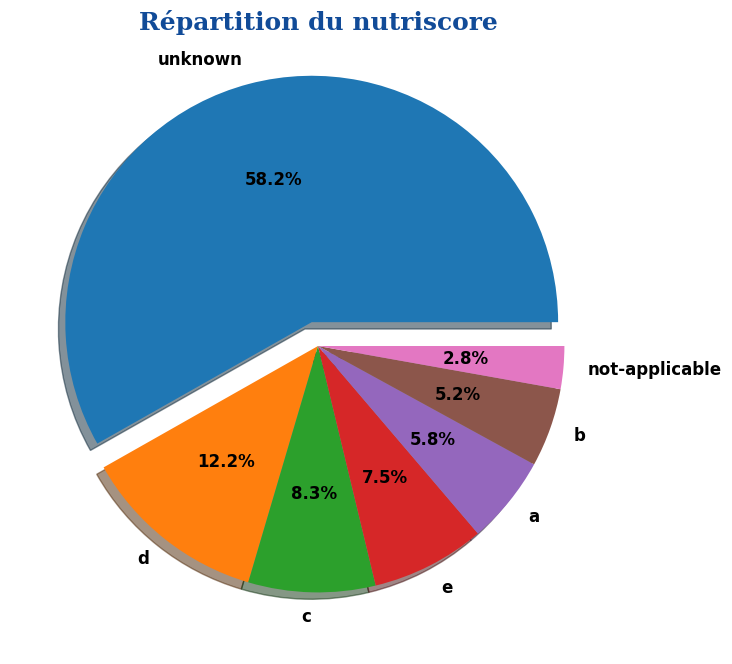

In [15]:
nutriscore = df_france_cleaned.groupby(by='nutriscore_grade')['code'].nunique().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

explodes = np.zeros(len(nutriscore))
explodes[0] = 0.1  # If you want to explode the first slice

plt.pie(nutriscore, labels=nutriscore.index,
        startangle=0,
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black", size=12, weight="bold"))
plt.title("Répartition du nutriscore", fontdict=font_title)
plt.show()


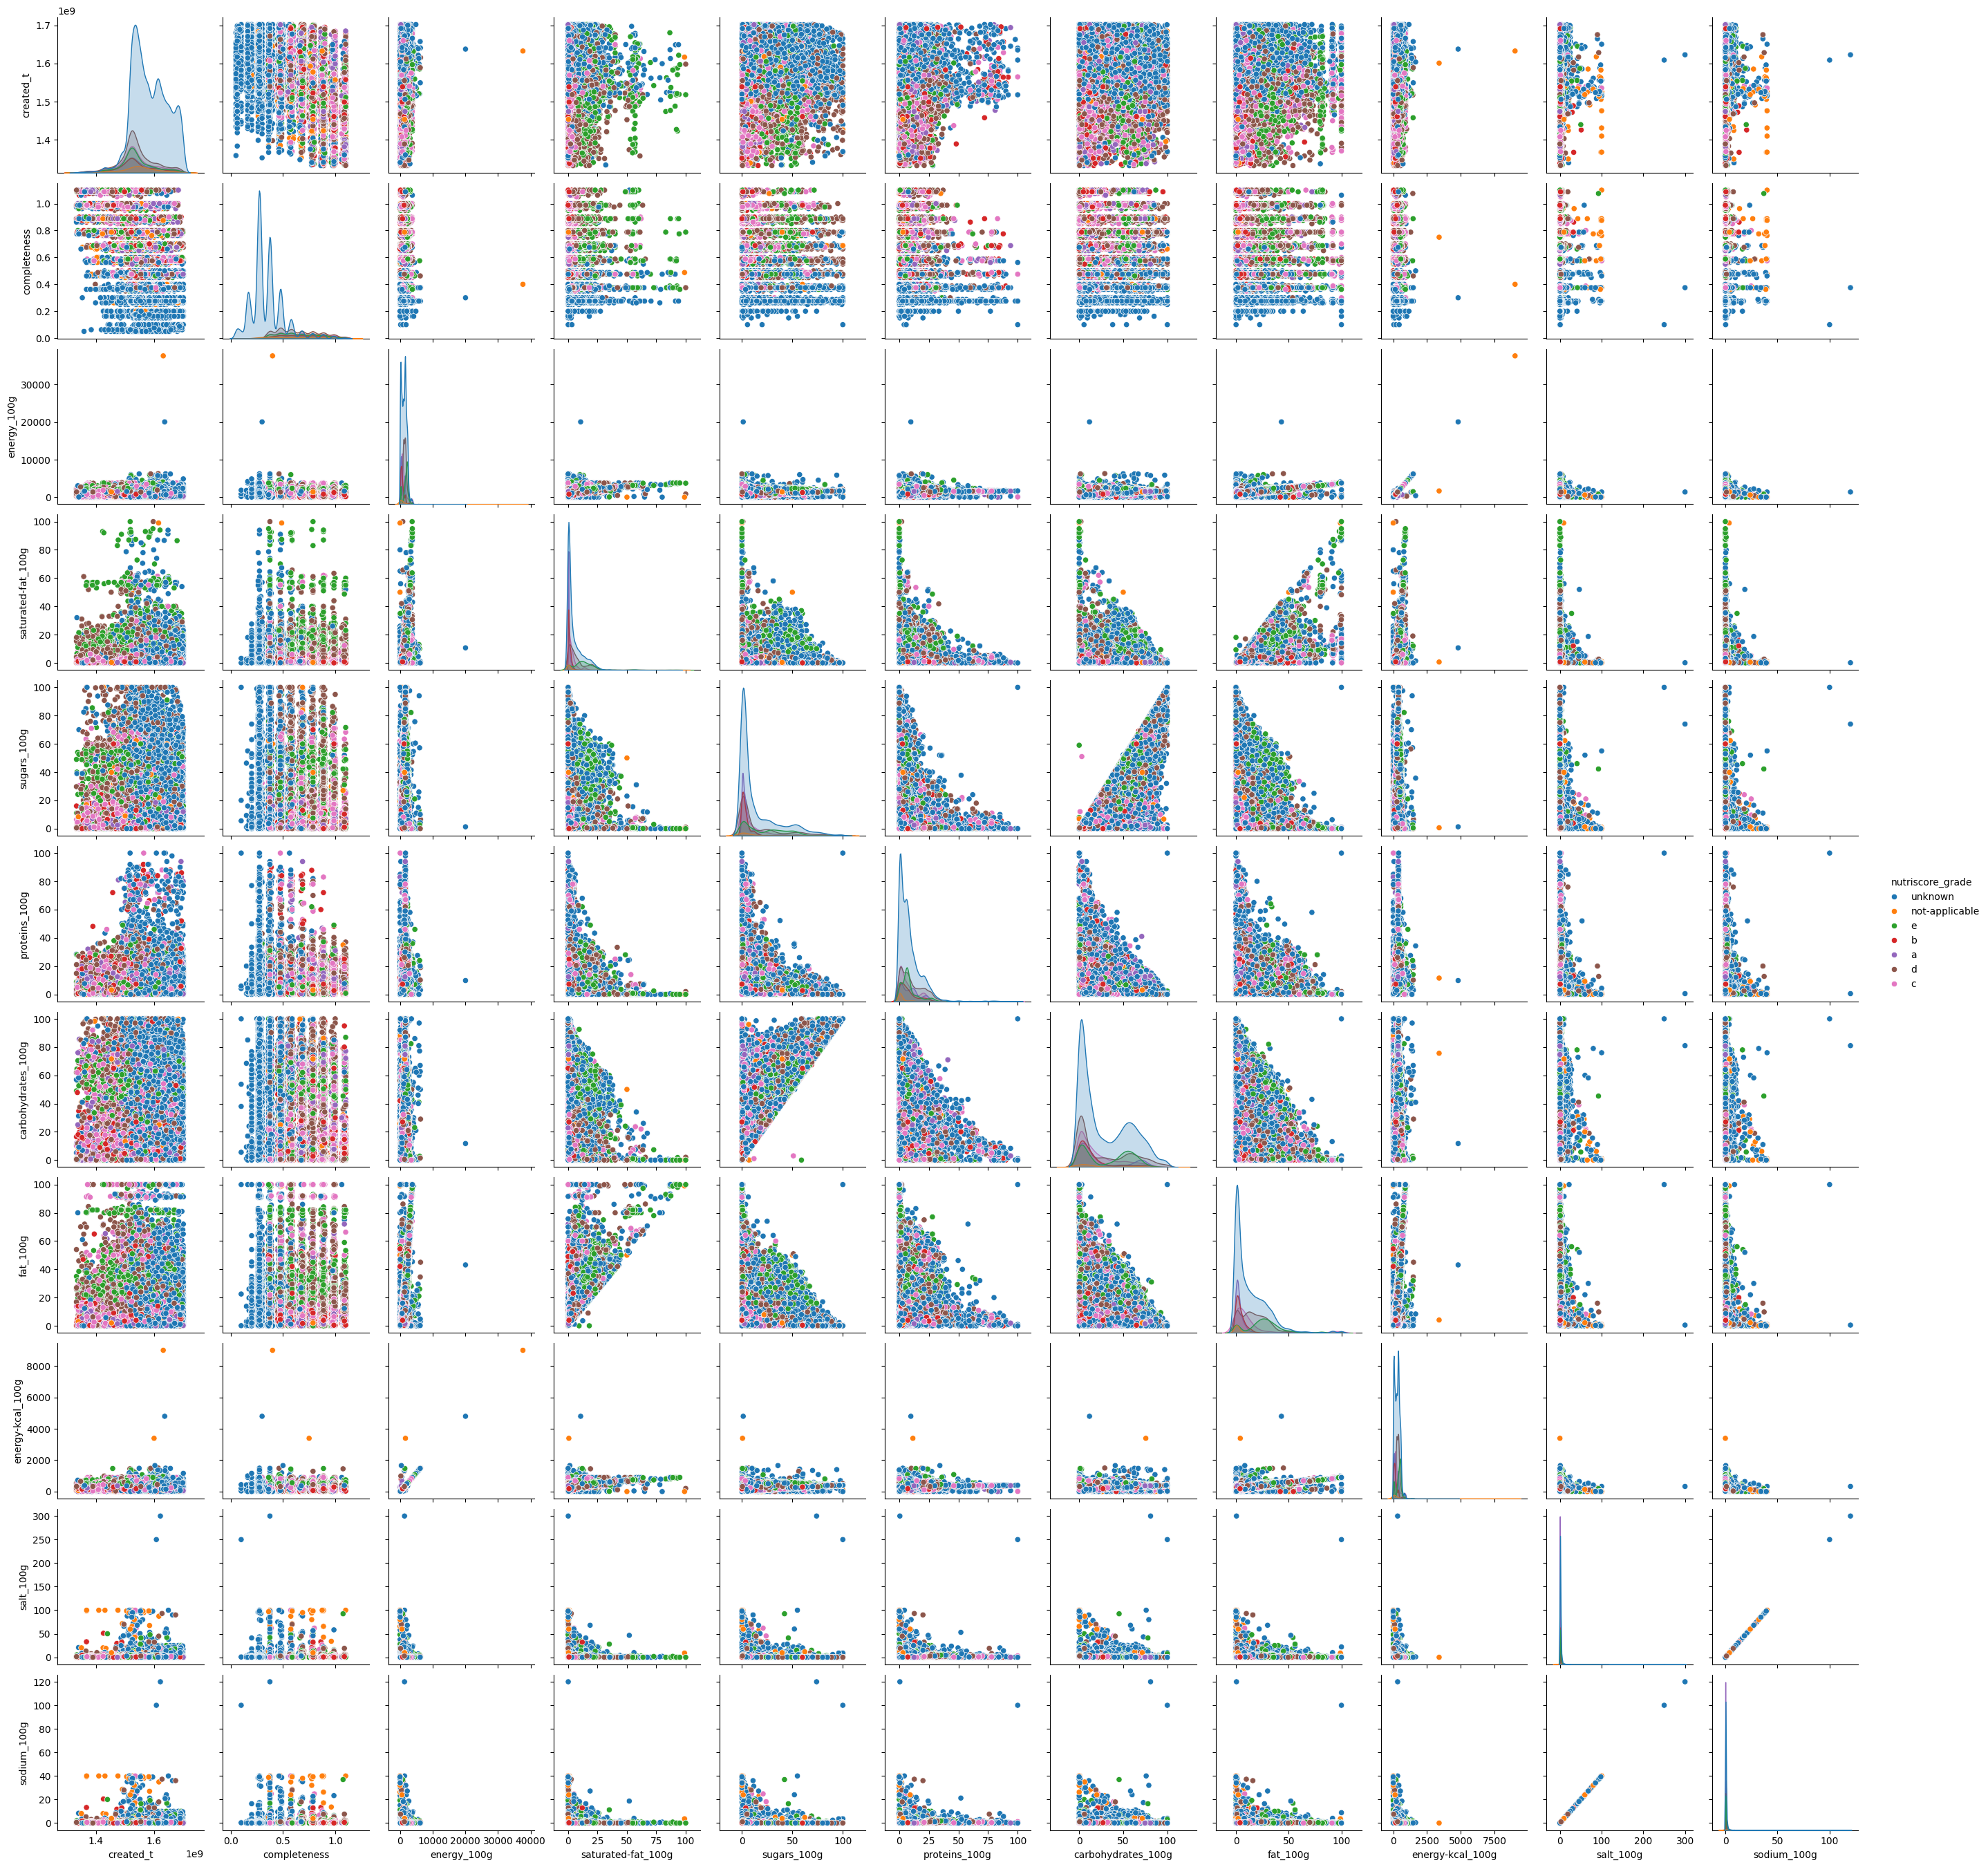

In [16]:
#analyse des corrélations


df_nutriscore = df_france_cleaned[(df_france_cleaned['nutriscore_grade'].isnull()==False)]

sns.pairplot(df_nutriscore.sample(frac=0.05), hue="nutriscore_grade")


C:\Users\luneb\AppData\Local\Temp\ipykernel_22012\2267743716.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


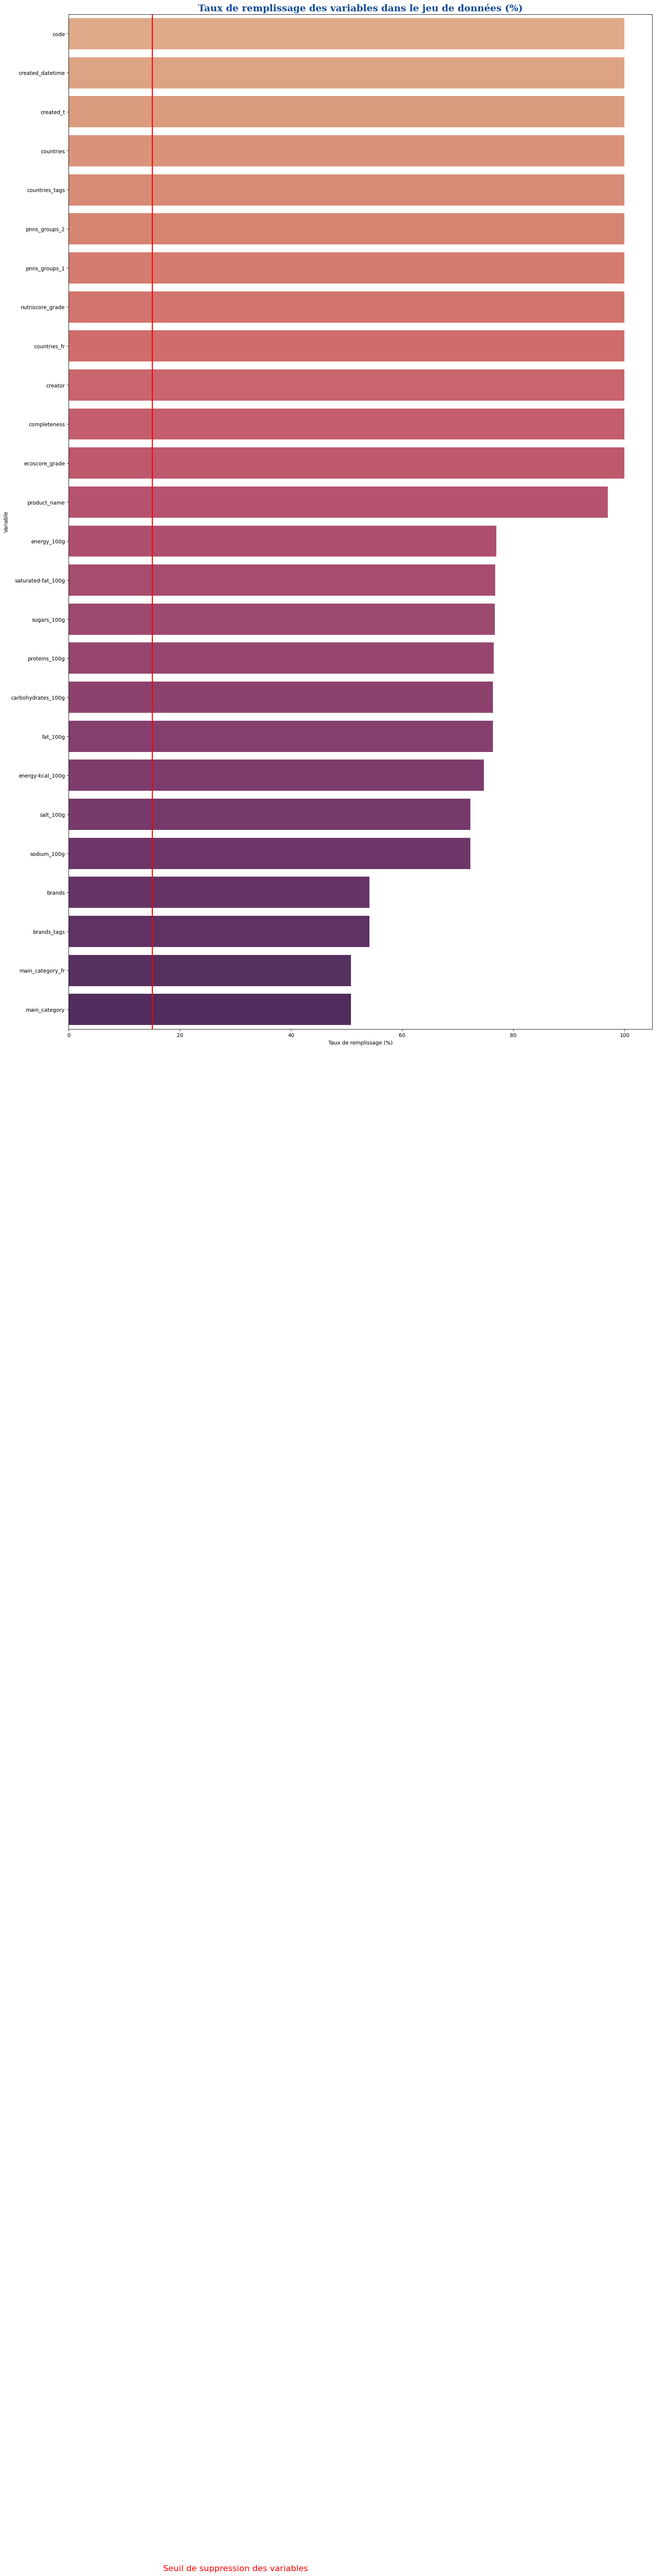

In [17]:
#Nous alllons désormais commencer à nettoyer la base de données en enlevant les colonnes peu remplis. 

filling_features = null_factor(df_france_cleaned)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 15

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [21]:
#on réalise une première régression. 

# Sélection des variables pour la régression linéaire
reg_variables = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g', 'energy-kcal_100g', 'sodium_100g', 'salt_100g', 'nutriscore_grade']

# Création d'un sous-ensemble de données avec les variables sélectionnées et suppression des lignes avec des valeurs manquantes dans la variable cible
data_reg = df_france_cleaned[reg_variables].dropna()

# Séparation des variables indépendantes (X) et de la variable cible (y)
X_reg = data_reg.drop(['nutriscore_grade'], axis=1)
y_reg = data_reg['nutriscore_grade']

# Initialisation et entraînement du modèle de régression linéaire
model_reg = LinearRegression()
model_reg.fit(X_reg, y_reg)

# Prédiction sur l'ensemble de données
y_pred_reg = model_reg.predict(X_reg)

# Évaluation du modèle sur l'ensemble avec nutriscore renseigné
mse_reg = mean_squared_error(y_reg, y_pred_reg)
r2_reg = r2_score(y_reg, y_pred_reg)

print(f'Mean Squared Error (avec nutriscore renseigné) : {mse_reg}')
print(f'R-squared (avec nutriscore renseigné) : {r2_reg}')

# Représentation graphique des prédictions par rapport aux valeurs réelles
plt.figure(figsize=(10, 6))
sns.scatterplot(y_reg, y_pred_reg)
plt.title('Régression linéaire - Prédictions vs Valeurs réelles (variables sélectionnées)')
plt.xlabel('Valeurs réelles (nutriscore_grade)')
plt.ylabel('Prédictions')
plt.show()







ValueError: could not convert string to float: 'a'